<a href="https://colab.research.google.com/github/phantruong1905/Fraud-Detection/blob/main/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()  # Upload the kaggle.json file here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"phanvntrng","key":"462fc0630a2c2e975ae76614ccf2ebe7"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d priyamchoksi/credit-card-transactions-dataset

Dataset URL: https://www.kaggle.com/datasets/priyamchoksi/credit-card-transactions-dataset
License(s): apache-2.0


In [ ]:
import zipfile
import os
with zipfile.ZipFile('credit-card-transactions-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('credit_card_data')

print(os.listdir('credit_card_data'))

['credit_card_transactions.csv']


In [ ]:
import pandas as pd

data_path = 'credit_card_data/credit_card_transactions.csv'
df = pd.read_csv(data_path)
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,28705.0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,NaN
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,83236.0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,NaN
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,22844.0


**DATA PREPROCESSING**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 24 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
import pandas as pd

def drop_cards_by_time_span(transactions_df, min_time_span=500):
    """
    Drops credit cards (cc_num) with a time span less than min_time_span days.

    Args:
        transactions_df (pd.DataFrame): Data with columns ['cc_num', 'trans_date_trans_time'].
        min_time_span (int): Minimum required time span (days).

    Returns:
        pd.DataFrame: Filtered transaction data with only valid cc_num.
    """
    # Ensure timestamp is in datetime format
    transactions_df['trans_date_trans_time'] = pd.to_datetime(transactions_df['trans_date_trans_time'])

    # Calculate time span (max - min date) for each cc_num
    card_time_spans = transactions_df.groupby('cc_num')['trans_date_trans_time'].agg(['min', 'max'])
    card_time_spans['time_span_days'] = (card_time_spans['max'] - card_time_spans['min']).dt.days

    # Get valid credit cards (those with time span >= min_time_span)
    valid_cards = card_time_spans[card_time_spans['time_span_days'] >= min_time_span].index

    # Filter the original DataFrame to keep only valid cc_num
    filtered_df = transactions_df[transactions_df['cc_num'].isin(valid_cards)]

    return filtered_df

# Apply the filter
df = drop_cards_by_time_span(df, min_time_span=500)

# Print results
print(f"Total transactions: {df.shape[0]}")
print(f"Unique credit cards: {df['cc_num'].nunique()}")

Total transactions: 1295934
Unique credit cards: 908


In [ ]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,28705.0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,NaN
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,83236.0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,NaN
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,22844.0


In [ ]:
df.drop(columns=['Unnamed: 0', 'first', 'last', 'street', 'merch_zipcode'], inplace=True)

# Convert `trans_date_trans_time` and `dob` to datetime format
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['dob'] = pd.to_datetime(df['dob'])

# Feature Engineering: Extract hour, day, and month from `trans_date_trans_time`
df['trans_hour'] = df['trans_date_trans_time'].dt.hour
df['trans_day_of_week'] = df['trans_date_trans_time'].dt.dayofweek
df['trans_month'] = df['trans_date_trans_time'].dt.month

# Feature Engineering: Calculate age from `dob`
current_year = pd.to_datetime('today').year
df['age'] = df['trans_date_trans_time'].dt.year - df['dob'].dt.year

# Feature Engineering: job categories
job_categories = {
    'Engineer': ['Engineer', 'Engineering', 'Civil engineer', 'Structural engineer', 'Electrical engineer', 'Mechanical engineer'],
    'Medical': ['Doctor', 'Nurse', 'Surgeon', 'Physiotherapist', 'Psychologist', 'Radiographer', 'Pharmacist'],
    'Teacher/Education': ['Teacher', 'Professor', 'Lecturer', 'Education', 'Tutor', 'Researcher', 'Counsellor'],
    'IT': ['Programmer', 'Developer', 'Data scientist', 'IT consultant', 'Systems analyst', 'Network engineer'],
    'Legal': ['Solicitor', 'Lawyer', 'Barrister', 'Legal', 'Attorney'],
    'Finance': ['Banker', 'Accountant', 'Investment', 'Financial', 'Auditor', 'Trader'],
}

def categorize_job(job_title):
    for category, keywords in job_categories.items():
        if any(keyword in job_title for keyword in keywords):
            return category
    return 'Other'

df['job_category'] = df['job'].apply(categorize_job)

df.drop(columns=['job'], inplace=True)

In [ ]:
# Haversine formula to calculate distance between two points on the Earth's surface in kilometers
def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    r = 6371
    return r * c

df['distance'] = haversine(df['lat'], df['long'], df['merch_lat'], df['merch_long'])

# Extract first 3 digits of ZIP code
df["zip_prefix"] = df["zip"].astype(str).str[:3].astype(int)
df["zip_prefix"] = pd.to_numeric(df["zip_prefix"], errors="coerce")

# Drop columns
drop_cols = [
    "dob", "unix_time", "lat", "long",
    "merch_lat", "merch_long", "city", "state", "trans_num", "zip"
]

df_cleaned = df.drop(columns=drop_cols)

**EDA & Visualization**

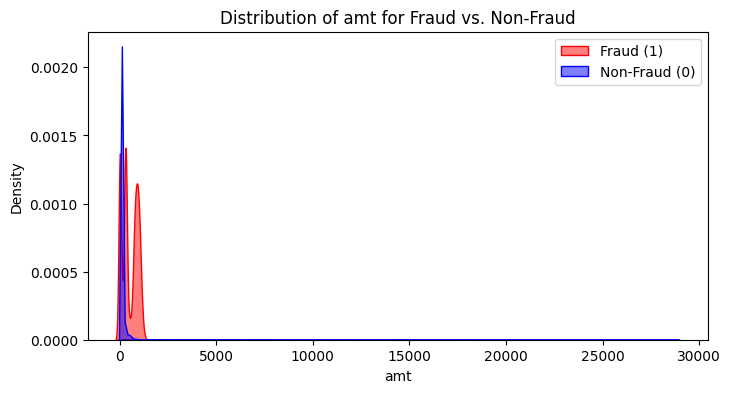

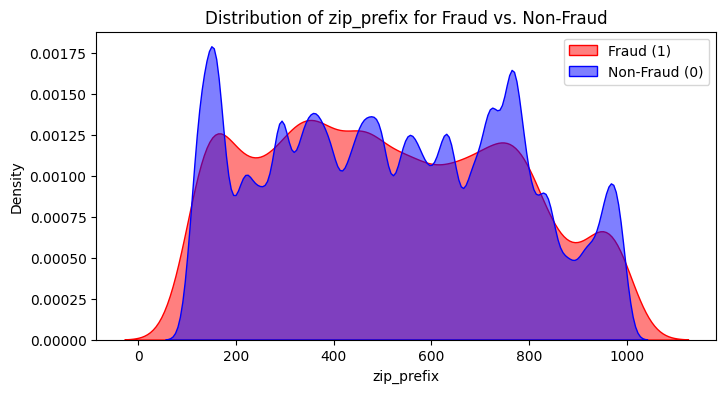

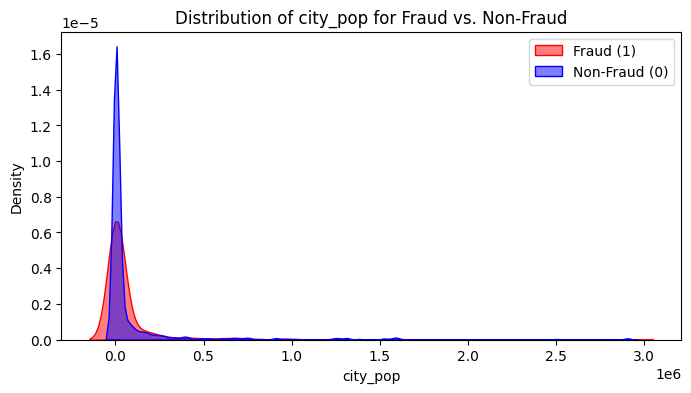

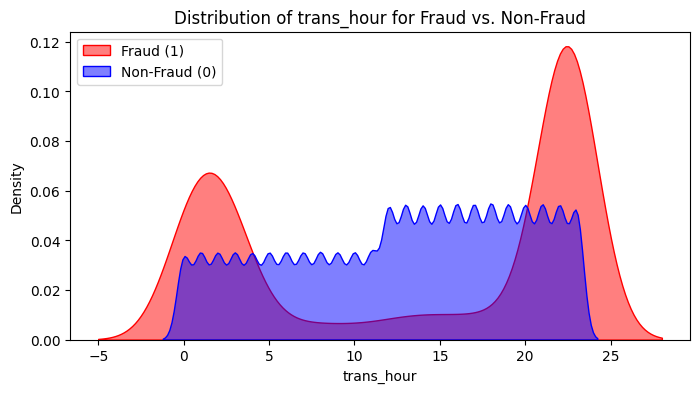

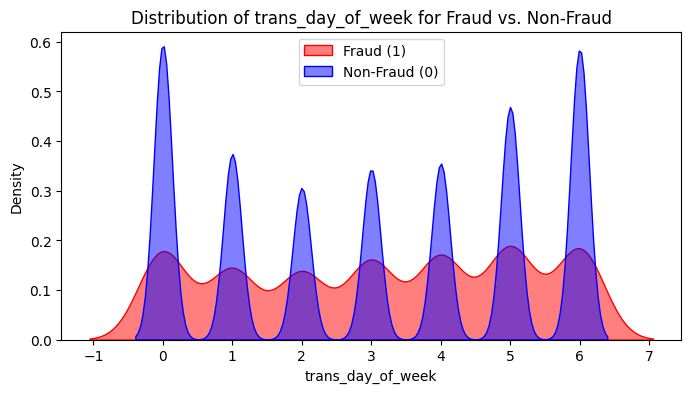

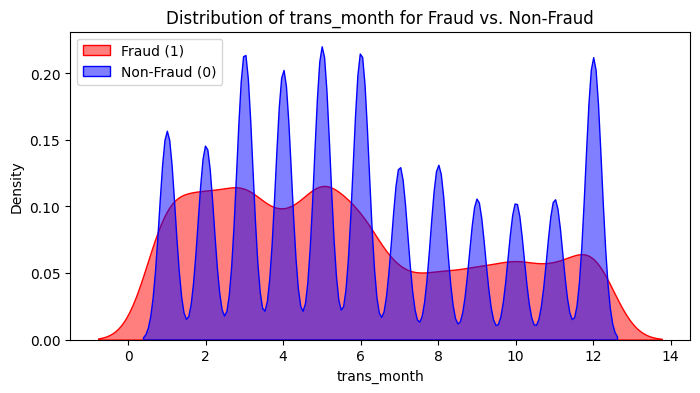

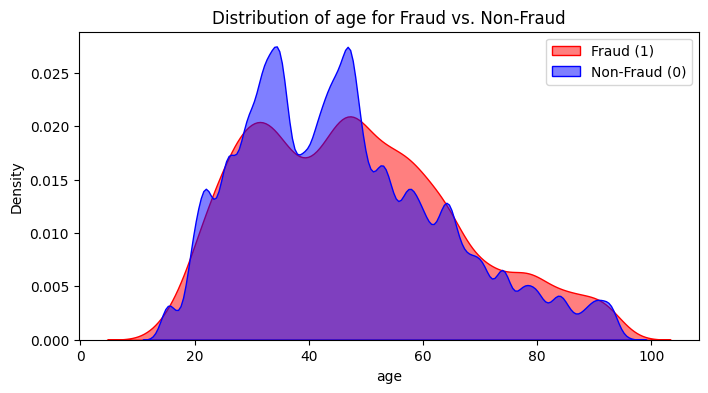

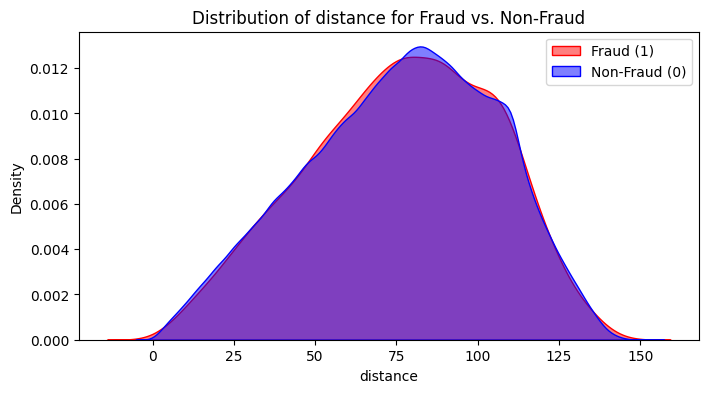

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Separate fraud and non-fraud data
fraud_df = df[df['is_fraud'] == 1]
nonfraud_df = df[df['is_fraud'] == 0]

# Get numerical and categorical columns
num_features_plot = ['amt', 'zip_prefix', 'city_pop', 'trans_hour', 'trans_day_of_week', 'trans_month', 'age', 'distance']
cat_features_plot = ['category', 'gender', 'job_category', 'merchant']

# Plot numerical feature distributions
for col in num_features_plot:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(fraud_df[col], label="Fraud (1)", fill=True, color="red", alpha=0.5)
    sns.kdeplot(nonfraud_df[col], label="Non-Fraud (0)", fill=True, color="blue", alpha=0.5)
    plt.title(f'Distribution of {col} for Fraud vs. Non-Fraud')
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.legend()
    plt.show()

<Figure size 1000x500 with 0 Axes>

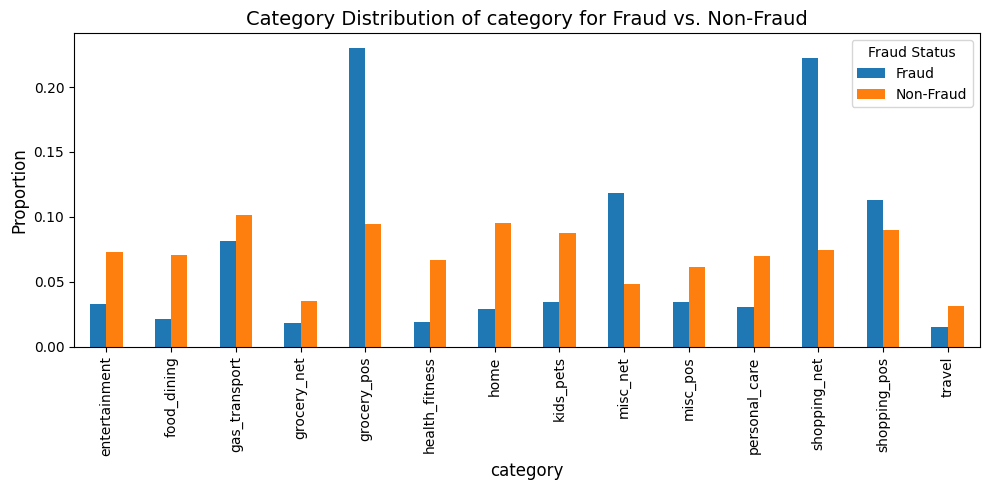

<Figure size 1000x500 with 0 Axes>

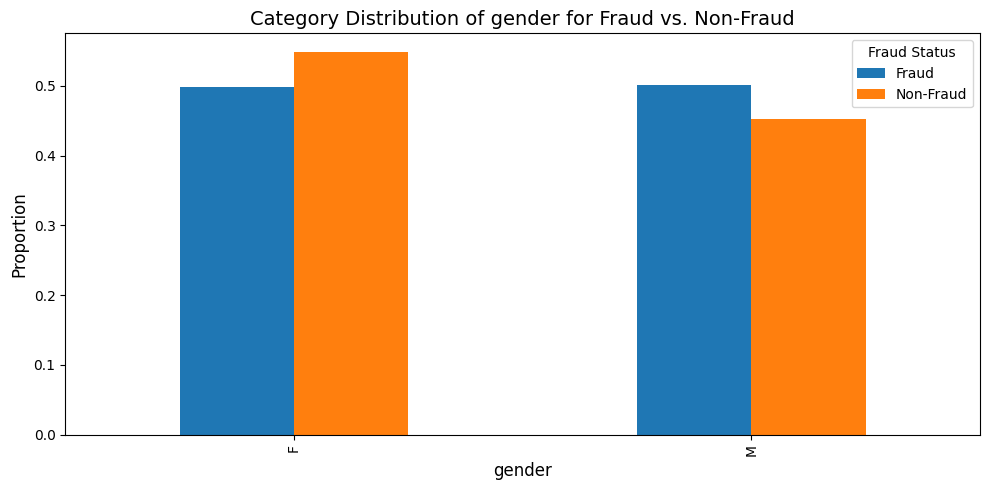

<Figure size 1000x500 with 0 Axes>

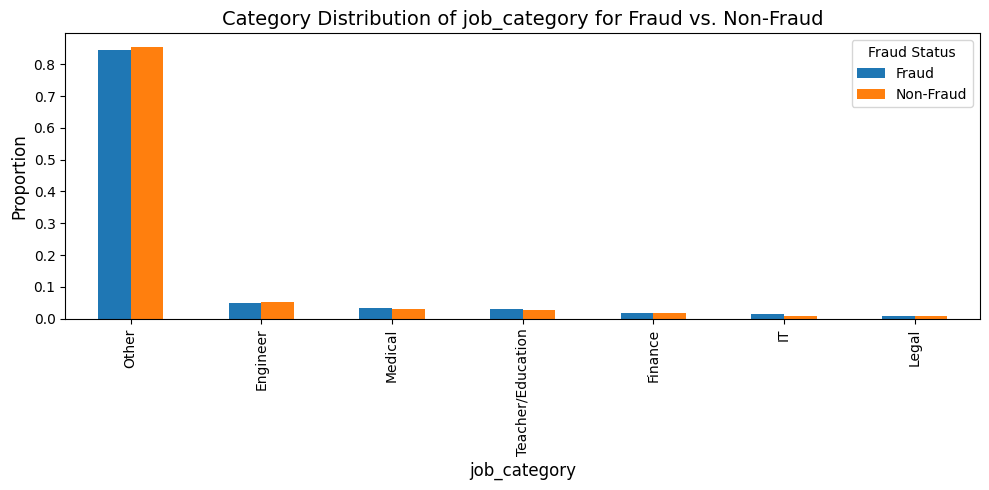

<Figure size 1000x500 with 0 Axes>

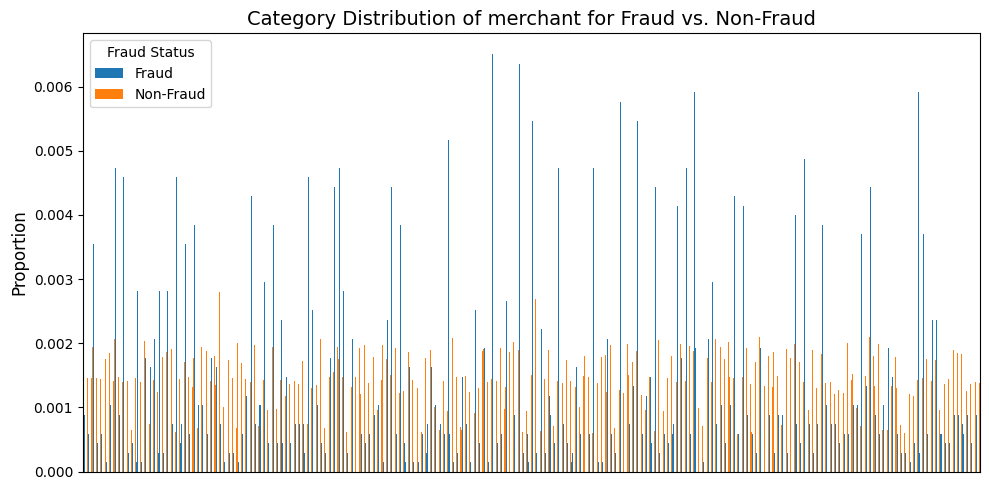

In [ ]:
# Plot categorical feature distributions
for col in cat_features_plot:
    plt.figure(figsize=(10, 5))

    # Calculate normalized value counts
    fraud_counts = fraud_df[col].value_counts(normalize=True)
    nonfraud_counts = nonfraud_df[col].value_counts(normalize=True)

    # Combine the counts, filling NaN with 0
    df_plot = pd.DataFrame({
        'Fraud': fraud_counts,
        'Non-Fraud': nonfraud_counts
    }).fillna(0)

    # Plot as a grouped bar chart
    df_plot.plot(kind='bar', figsize=(10, 5))

    plt.title(f'Category Distribution of {col} for Fraud vs. Non-Fraud', fontsize=14)

    # Special handling for merchant column
    if col == "merchant":
        plt.xlabel("")  # No x-axis label
        plt.xticks([])  # Remove x-axis ticks
    else:
        plt.xlabel(col, fontsize=12)
        plt.xticks(rotation=90)

    plt.ylabel("Proportion", fontsize=12)
    plt.legend(title="Fraud Status", loc='best')

    # Adjust layout to prevent cutting off labels
    plt.tight_layout()
    plt.show()

**OUTLIERS HANDLING**

In [ ]:
num_features = ['amt', 'city_pop', 'trans_hour', 'trans_day_of_week', 'trans_month', 'age', 'distance']
cat_features = ['category', 'gender', 'job_category', 'merchant', 'zip_prefix']

In [ ]:
# Define percentile thresholds for each numerical feature
lower_bound = df_cleaned[num_features].quantile(0.05)
upper_bound = df_cleaned[num_features].quantile(0.95)

# Apply capping per column
df_cleaned[num_features] = df_cleaned[num_features].apply(
    lambda x: np.clip(x, lower_bound[x.name], upper_bound[x.name])
)

print(df_cleaned.shape)

(1295934, 15)


In [ ]:
df_cleaned.head()

,trans_date_trans_time,cc_num,merchant,category,amt,gender,city_pop,is_fraud,trans_hour,trans_day_of_week,trans_month,age,job_category,distance,zip_prefix
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.9700,F,3495,0,1,1,1,31,Medical,78.597568,286
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.2300,F,149,0,1,1,1,41,Other,30.212176,991
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,195.6335,M,4154,0,1,1,1,57,Other,108.206083,832
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.0000,M,1939,0,1,1,1,52,Other,95.673231,596
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.9600,M,139,0,1,1,1,33,Other,77.556744,244


**BASE LINE ML MODELS**

**SPLIT DATA & ENCODING**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Define features
num_features = ['amt', 'city_pop', 'age', 'distance']
freq_features = ["merchant", "zip_prefix", "category", "job_category"]
cyclic_features = ["trans_hour", "trans_day_of_week", "trans_month"]
onehot_cols = ["gender"]

X = df_cleaned.drop(columns=["is_fraud"])  # Features
y = df_cleaned["is_fraud"]  # Target variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

**FREQUENCY/ ONE-HOT ENCODING**

In [ ]:
# Frequency encoding
def frequency_encode(train, test, col):
    freq_map = train[col].value_counts(normalize=True)  # Compute frequency on train only
    train[col + "_freq"] = train[col].map(freq_map).fillna(0)
    test[col + "_freq"] = test[col].map(freq_map).fillna(0)  # Apply same mapping to test
    train.drop(columns=[col], inplace=True)
    test.drop(columns=[col], inplace=True)

for col in freq_features:
    frequency_encode(X_train, X_test, col)

# One-hot encoding for 'gender'
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
onehot_encoded_train = encoder.fit_transform(X_train[onehot_cols])
onehot_encoded_test = encoder.transform(X_test[onehot_cols])

In [ ]:
# Convert to DataFrame
onehot_X_train = pd.DataFrame(onehot_encoded_train, columns=encoder.get_feature_names_out(onehot_cols))
onehot_X_test = pd.DataFrame(onehot_encoded_test, columns=encoder.get_feature_names_out(onehot_cols))

# Drop original categorical columns and merge encoded ones
X_train.drop(columns=onehot_cols, inplace=True)
X_test.drop(columns=onehot_cols, inplace=True)

X_train = pd.concat([X_train.reset_index(drop=True), onehot_X_train], axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), onehot_X_test], axis=1)

X_train = X_train.drop(columns=["trans_date_trans_time", "gender_M"])
X_test = X_test.drop(columns=["trans_date_trans_time", "gender_M"])

**SMOTEENN**

In [ ]:
from imblearn.combine import SMOTEENN

# Initialize SMOTE
smote_enn = SMOTEENN(random_state=42)

# Apply SMOTE to training data
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

print(X_train_resampled.shape)
print(y_train_resampled.shape)

(1959502, 13)
(1959502,)


In [ ]:
y_train_resampled.value_counts()

,count
is_fraud,
1,1010903
0,948599


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

# Predict
y_pred_rf = rf.predict(X_test)

# Evaluate
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.76      0.75      0.75      1353

    accuracy                           1.00    259187
   macro avg       0.88      0.87      0.88    259187
weighted avg       1.00      1.00      1.00    259187



In [ ]:
from xgboost import XGBClassifier

# Initialize and train
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb.fit(X_train_resampled, y_train_resampled)

# Predict
y_pred_xgb = xgb.predict(X_test)

# Evaluate
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:39:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    257834
           1       0.32      0.89      0.47      1353

    accuracy                           0.99    259187
   macro avg       0.66      0.94      0.73    259187
weighted avg       1.00      0.99      0.99    259187



**SPLIT DATA**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

df_cleaned_2 = df_cleaned.copy()

# Define feature sets
num_features_dl = ['amt', 'city_pop', 'age', 'distance']
freq_features_dl = ["merchant", "zip_prefix"]
cyclic_features_dl = ["trans_hour", "trans_day_of_week", "trans_month"]
onehot_cols_dl = ["category", "job_category"]

# Set `cc_num` as Index
df_cleaned_2.set_index("cc_num", inplace=True)

# Encode gender
df_cleaned_2['gender'] = df_cleaned_2['gender'].map({'M': 0, 'F': 1})

# Encode Cyclic Features BEFORE Splitting
def encode_cyclic_features(df, col, max_val):
    df[f"{col}_sin"] = np.sin(2 * np.pi * df[col] / max_val)
    df[f"{col}_cos"] = np.cos(2 * np.pi * df[col] / max_val)
    df[f"{col}_sincos"] = df[f"{col}_sin"] * df[f"{col}_cos"]
    df.drop(columns=[col], inplace=True)
    return df

for col in cyclic_features_dl:
    df_cleaned_2 = encode_cyclic_features(df_cleaned_2, col, max_val={'trans_hour': 24, 'trans_day_of_week': 7, 'trans_month': 12}[col])

# Group by credit card and sort each group by transaction time
grouped = df_cleaned_2.groupby("cc_num", group_keys=False).apply(lambda x: x.sort_values(by="trans_date_trans_time"))

# Define split ratios
train_ratio, val_ratio = 0.8, 0.1  # 80% train, 10% val, 10% test

# Function to split each credit card's transactions by time
def time_split(group):
    train_end = int(len(group) * train_ratio)
    val_end = int(len(group) * (train_ratio + val_ratio))

    train = group.iloc[:train_end]
    val = group.iloc[train_end:val_end]
    test = group.iloc[val_end:]

    return train, val, test

# Apply time-based split per `cc_num`
train_list, val_list, test_list = zip(*grouped.groupby(level=0, group_keys=False).apply(time_split))

# Concatenate results
X_train = pd.concat(train_list)
X_val = pd.concat(val_list)
X_test = pd.concat(test_list)

print(f"Train Size: {len(X_train)}, Validation Size: {len(X_val)}, Test Size: {len(X_test)}")

# Frequency Encoding (Keep zip_prefix for edge creation)
def frequency_encode(train, val, test, col, keep_original=False):
    freq_map = train[col].value_counts(normalize=True)
    train[col + "_freq"] = train[col].map(freq_map).fillna(0)
    val[col + "_freq"] = val[col].map(freq_map).fillna(0)
    test[col + "_freq"] = test[col].map(freq_map).fillna(0)

    if not keep_original:
        train.drop(columns=[col], inplace=True)
        val.drop(columns=[col], inplace=True)
        test.drop(columns=[col], inplace=True)

# Apply frequency encoding but keep zip_prefix
for col in freq_features_dl:
    keep_original = col == "zip_prefix"
    frequency_encode(X_train, X_val, X_test, col, keep_original=keep_original)

# One-Hot Encoding
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
onehot_encoded_train = encoder.fit_transform(X_train[onehot_cols_dl])
onehot_encoded_val = encoder.transform(X_val[onehot_cols_dl])
onehot_encoded_test = encoder.transform(X_test[onehot_cols_dl])

# Convert to DataFrame
onehot_X_train = pd.DataFrame(onehot_encoded_train, columns=encoder.get_feature_names_out(onehot_cols_dl), index=X_train.index)
onehot_X_val = pd.DataFrame(onehot_encoded_val, columns=encoder.get_feature_names_out(onehot_cols_dl), index=X_val.index)
onehot_X_test = pd.DataFrame(onehot_encoded_test, columns=encoder.get_feature_names_out(onehot_cols_dl), index=X_test.index)

# Drop original categorical columns and merge encoded ones
X_train.drop(columns=onehot_cols_dl, inplace=True)
X_val.drop(columns=onehot_cols_dl, inplace=True)
X_test.drop(columns=onehot_cols_dl, inplace=True)

# MinMaxScaling numerical features
scaler = MinMaxScaler()

# Fit on training data & transform train, val, and test sets
X_train[num_features_dl] = scaler.fit_transform(X_train[num_features_dl])
X_val[num_features_dl] = scaler.transform(X_val[num_features_dl])
X_test[num_features_dl] = scaler.transform(X_test[num_features_dl])

X_train = pd.concat([X_train, onehot_X_train], axis=1)
X_val = pd.concat([X_val, onehot_X_val], axis=1)
X_test = pd.concat([X_test, onehot_X_test], axis=1)


print("Feature Engineering Completed!")

# Create Graph Edges Using `zip_prefix`
import networkx as nx

def create_edges_from_zip(df):
    G = nx.Graph()

    # Add nodes (each credit card has all features except target variable)
    for cc_num in df.index.unique():
        node_features = df.loc[cc_num].values  # Use all features
        G.add_node(cc_num, features=node_features)

    # Add edges where zip_prefix matches
    grouped = df.groupby('zip_prefix')
    for _, group in grouped:
        card_ids = group.index.unique()
        for i in range(len(card_ids)):
            for j in range(i+1, len(card_ids)):
                G.add_edge(card_ids[i], card_ids[j])

    return G

# Create graph from X_train only
graph = create_edges_from_zip(X_train)

print(f"Graph created with {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges.")

NameError: name 'df_cleaned' is not defined

In [ ]:
X_train = X_train.drop(columns='zip_prefix')
X_val = X_val.drop(columns='zip_prefix')
X_test = X_test.drop(columns='zip_prefix')

**LSTM ONLY**

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader

def create_lstm_sequences(df, seq_length=19):
    X_seq, y_seq = [], []
    for cc_num, group in df.groupby(level=0):
        group = group.sort_values(by="trans_date_trans_time")
        features = group.drop(columns=["trans_date_trans_time", "is_fraud"]).values
        labels = group["is_fraud"].values

        for i in range(len(features) - seq_length):
            past_X = features[i:i + seq_length]
            next_X = features[i + seq_length].reshape(1, -1)
            X_seq.append(np.vstack([past_X, next_X]))
            y_seq.append(labels[i + seq_length])

    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)


def prepare_dataloaders(X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, y_test_seq, batch_size=64, use_gpu=True):
    device = torch.device("cuda" if torch.cuda.is_available() and use_gpu else "cpu")
    print(f"Using device: {device}")

    # Convert NumPy arrays to PyTorch tensors
    def to_tensor(data, is_label=False):
        tensor = torch.tensor(data, dtype=torch.float32)
        return tensor if is_label else tensor

    X_train_tensor = to_tensor(X_train_seq)
    y_train_tensor = to_tensor(y_train_seq, is_label=True)
    X_val_tensor = to_tensor(X_val_seq)
    y_val_tensor = to_tensor(y_val_seq, is_label=True)
    X_test_tensor = to_tensor(X_test_seq)
    y_test_tensor = to_tensor(y_test_seq, is_label=True)

    # Create datasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # Dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, device



# Create sequences
X_train_seq, y_train_seq = create_lstm_sequences(X_train)
X_val_seq, y_val_seq = create_lstm_sequences(X_val)
X_test_seq, y_test_seq = create_lstm_sequences(X_test)

# Prepare loaders
train_loader, val_loader, test_loader, device = prepare_dataloaders(
    X_train_seq, y_train_seq,
    X_val_seq, y_val_seq,
    X_test_seq, y_test_seq,
)

print(f"DataLoaders ready — Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")

In [ ]:
# Sort dataset by transaction time
cleaned_df = df_cleaned.sort_values(by="trans_date_trans_time")

# Define time split (e.g., 80% train, 10% validation, 10% test)
train_size = int(0.8 * len(cleaned_df))
val_size = int(0.9 * len(cleaned_df))  # 80% train, next 10% validation, last 10% test

# Perform split
X_train, X_val, X_test = cleaned_df.iloc[:train_size], cleaned_df.iloc[train_size:val_size], cleaned_df.iloc[val_size:]

print(f"Train Size: {len(X_train)}, Validation Size: {len(X_val)}, Test Size: {len(X_test)}")

import torch
from torch.utils.data import TensorDataset, DataLoader

# Move data to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32).to(device)

X_val_tensor = torch.tensor(X_val_seq, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val_seq, dtype=torch.float32).to(device)

X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_seq, dtype=torch.float32).to(device)

# Create PyTorch datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders for batch processing
batch_size = 64  # Can be tuned
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}")

In [ ]:
import torch
import torch.nn as nn

class FraudLSTM_Attn(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=3, dropout=0.3):
        super(FraudLSTM_Attn, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM Layer (Stateful)
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim,
                            num_layers=num_layers, dropout=dropout,
                            batch_first=True, bidirectional=False)

        # Attention Layers (Query, Key, Value)
        self.query_layer = nn.Linear(hidden_dim, hidden_dim)  # Query
        self.key_layer = nn.Linear(hidden_dim, hidden_dim)  # Key
        self.value_layer = nn.Linear(hidden_dim, hidden_dim)  # Value

        self.softmax = nn.Softmax(dim=2)  # Normalize across time steps (dim=2)

        # Fully Connected Decoder
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )


        # Store Hidden State (Stateful)
        self.hidden_state = None

    def reset_hidden_state(self, batch_size, device):
        """Reset hidden state manually (for stateful training)."""
        self.hidden_state = (
            torch.zeros(self.num_layers, batch_size, self.hidden_dim, device=device),
            torch.zeros(self.num_layers, batch_size, self.hidden_dim, device=device)
        )

    def forward(self, x):
        batch_size, seq_len, _ = x.shape

        # Initialize hidden state if first batch
        if self.hidden_state is None or self.hidden_state[0].size(1) != batch_size:
            self.reset_hidden_state(batch_size, x.device)

        # LSTM Forward (Stateful)
        h, c = self.hidden_state
        self.hidden_state = (h.detach(), c.detach())
        lstm_out, self.hidden_state = self.lstm(x, self.hidden_state)

        # Compute Queries, Keys, Values
        Q = self.query_layer(lstm_out)  # (batch, 20, hidden_dim)
        K = self.key_layer(lstm_out)  # (batch, 20, hidden_dim)
        V = self.value_layer(lstm_out)  # (batch, 20, hidden_dim)

        # Attention Score Calculation (Scaled Dot-Product Attention)
        attn_scores = torch.bmm(Q, K.transpose(1, 2))  # (batch, 20, 20)
        attn_weights = self.softmax(attn_scores)  # (batch, 20, 20)

        # Apply attention to values
        context_vector = torch.bmm(attn_weights, V)  # (batch, 20, hidden_dim)

        # Aggregate all hidden states (Mean Pooling)
        H_att = torch.mean(context_vector, dim=1)  # (batch, hidden_dim)

        # Fully Connected Decoder
        output = self.fc(H_att)  # (batch, 1)

        return output.view(-1)  # Ensure shape (batch_size,)


In [ ]:
import torch.optim as optim
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support

# Hyperparameters
input_dim = X_train_seq.shape[2]  # 39 features
hidden_dim = 128
num_layers = 3
dropout = 0.3
learning_rate = 0.001
num_epochs = 10
batch_size = 64

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FraudLSTM_Attn(input_dim, hidden_dim, num_layers, dropout).to(device)

# Define loss function & optimizer
pos_weight = torch.tensor([10.0]).to(device)  # Adjust based on class imbalance
criterion = nn.BCELoss(weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X).squeeze()  # Get predictions
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X).squeeze()

            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

            # Store predictions & labels for metrics
            all_preds.extend(outputs.cpu().numpy())  # Convert to numpy for sklearn
            all_labels.extend(batch_y.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)

    # Convert predictions to binary (threshold=0.5)
    all_preds_bin = [1 if p >= 0.5 else 0 for p in all_preds]

    # Compute AUC, Precision, Recall, F1
    auc = roc_auc_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds_bin, average="binary", zero_division=0)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f} - AUC: {auc:.4f} - Precision: {precision:.4f} - Recall: {recall:.4f} - F1: {f1:.4f}")

print("Training Complete!")

**TEST**

In [ ]:
# Ensure model is in evaluation mode
model.eval()
test_loss = 0
all_test_preds, all_test_labels = [], []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X).squeeze()

        # Compute test loss
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()

        # Store predictions & labels for final metrics
        all_test_preds.extend(outputs.cpu().numpy())
        all_test_labels.extend(batch_y.cpu().numpy())

# Compute average test loss
avg_test_loss = test_loss / len(test_loader)

# Convert predictions to binary using the same threshold as validation
threshold = 0.3
all_test_preds_bin = [1 if p >= threshold else 0 for p in all_test_preds]

# Compute AUC, Precision, Recall, F1
test_auc = roc_auc_score(all_test_labels, all_test_preds)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
    all_test_labels, all_test_preds_bin, average="binary", zero_division=0
)

# Print final results
print("\n**Final Test Results** ")
print(f"Test Loss: {avg_test_loss:.4f} - AUC: {test_auc:.4f}")
print(f"Precision (Fraud): {test_precision:.4f} - Recall (Fraud): {test_recall:.4f} - F1 (Fraud): {test_f1:.4f}")

# Print full classification report (for both 0 & 1)
test_report = classification_report(all_test_labels, all_test_preds_bin, target_names=["Non-Fraud (0)", "Fraud (1)"])
print("\nClassification Report:\n", test_report)